In [1]:
using Revise 
using EuclidianNormalizingFlows

using BAT
using Distributions
using Optimisers
using FunctionChains
using ArraysOfArrays
using LinearAlgebra
using ValueShapes
using StatsBase
using FileIO
using JLD2
using CUDA
using CUDAKernels
using KernelAbstractions
using Flux
using PyPlot

┌ Info: Precompiling EuclidianNormalizingFlows [eb90128f-7c94-4cd6-9130-4bb7c9abac9d]
└ @ Base loading.jl:1664


In [2]:
n_smpls = 10^5

n_dims = 2
n_modes = 10

mvns = [MvNormal(10 .*rand(n_dims), 0.5 * abs(randn(1)[1]) .* I(n_dims)) for i in 1:n_modes]
d = MixtureModel(mvns)
importance_density = MvNormal(zeros(n_dims), I)
wanna_use_GPU = true
_device = wanna_use_GPU ? KernelAbstractions.get_device(CUDA.rand(10)) : KernelAbstractions.get_device(rand(10))
samples = bat_sample(d, BAT.IIDSampling(nsamples=n_smpls)).result;
smpls_flat = gpu(flatview(unshaped.(samples.v)));
samples_nested = wanna_use_GPU ? nestedview(gpu(smpls_flat)) : nestedview(smpls_flat);

proposal_density = convert(BAT.AbstractMeasureOrDensity, BAT.StandardMvNormal(n_dims))   
proposal_samples = bat_sample(proposal_density, 
                    BAT.IIDSampling(nsamples= n_smpls)).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /home/iwsatlas1/mdud/ACS/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /home/iwsatlas1/mdud/ACS/BAT.jl/src/algotypes/bat_default.jl:44


In [4]:
nbatches = 10
nepochs = 100
K = 40

blocks = get_flow_musketeer_dt(n_dims,_device,K)
lr = fill(3f-3, length(blocks.fs))
trained_blocks = Function[AdaptiveScaleShift()]
hists = Vector[]

smpls_train = samples_nested;

@time begin
    smpls_train = nestedview(trained_blocks[1](smpls_flat))
    
    for i in 1:n_dims
        println("+++ Starting round $i")
        
        r = optimize_whitening(smpls_train, 
            blocks.fs[1+i],
            Optimisers.Adam(lr[i]),
            nbatches=nbatches,
            nepochs=nepochs, 
            shuffle_samples =false)
            
        trained_trafo = r.result
        push!(trained_blocks, trained_trafo)
        push!(hists, r.negll_history)
        smpls_train = nestedview(trained_trafo(flatview(smpls_train)))
    end
end

push!(trained_blocks, AdaptiveScaleShift())
trained_flow = fchain(trained_blocks)
smpls_transformed, ladj_trafo = EuclidianNormalizingFlows.with_logabsdet_jacobian(trained_flow, smpls_flat)

smpls_transformed = cpu(smpls_transformed)
smpls_flat_cpu = cpu(smpls_flat)

integral_ghm, variance_ghm = ghm_integration(smpls_transformed, samples.logd, vec(cpu(ladj_trafo)), importance_density)

@show integral_ghm
@show variance_ghm

@time begin
    target_density = BAT.Transformed(convert(BAT.AbstractMeasureOrDensity,d), 
                                     cpu(trained_flow), 
                                     BAT.TDLADJCorr()
                                    )

    target_samples = DensitySampleVector(nestedview(cpu(smpls_transformed)), 
                                         samples.logd - vec(cpu(ladj_trafo))
                                        )

    integral_bs = BAT.bridge_sampling_integral(target_density,
                                               target_samples, 
                                               proposal_density,
                                               proposal_samples,
                                               true)
end
@show integral_bs

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[1].hist2d(smpls_flat_cpu[1,:], smpls_flat_cpu[2,:], [100,100], cmap="inferno")
ax[1].set_xlim([minimum(smpls_flat_cpu[1,:]), maximum(smpls_flat_cpu[1,:])])
ax[1].set_ylim([minimum(smpls_flat_cpu[2,:]), maximum(smpls_flat_cpu[2,:])])
ax[2].hist2d(smpls_transformed[1,:], smpls_transformed[2,:], [100,100], cmap="inferno")
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([-3, 3])

+++ Starting round 1


LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
     [1] [0m[1mwait[22m
    [90m   @ [39m[90m./[39m[90m[4masyncevent.jl:155[24m[39m[90m [inlined][39m
     [2] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m/user/.julia/packages/CUDAKernels/YWLqR/src/[39m[90m[4mCUDAKernels.jl:150[24m[39m[90m [inlined][39m
     [3] [0m[1m(::CUDAKernels.var"#8#11"{CUDAKernels.CudaEvent, Timer, CuDevice, Base.Event})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[35mCUDAKernels[39m [90m./[39m[90m[4mthreadingconstructs.jl:258[24m[39m

In [16]:
smpls_transformed = cpu(trained_blocks[2](smpls_flat))

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[1].hist2d(smpls_flat_cpu[1,:], smpls_flat_cpu[2,:], [100,100], cmap="inferno")
ax[1].set_xlim([minimum(smpls_flat_cpu[1,:]), maximum(smpls_flat_cpu[1,:])])
ax[1].set_ylim([minimum(smpls_flat_cpu[2,:]), maximum(smpls_flat_cpu[2,:])])
ax[2].hist2d(smpls_transformed[1,:], smpls_transformed[2,:], [100,100], cmap="inferno")
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([-3, 3])

LoadError: PyError ($(Expr(:escape, :(ccall(#= /user/.julia/packages/PyCall/ygXW2/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('autodetected range of [nan, nan] is not finite')
  File "/opt/anaconda3/lib/python3.9/site-packages/matplotlib/__init__.py", line 1412, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py", line 6976, in hist2d
    h, xedges, yedges = np.histogram2d(x, y, bins=bins, range=range,
  File "<__array_function__ internals>", line 5, in histogram2d
  File "/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/twodim_base.py", line 751, in histogram2d
    hist, edges = histogramdd([x, y], bins, range, normed, weights, density)
  File "<__array_function__ internals>", line 5, in histogramdd
  File "/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/histograms.py", line 1050, in histogramdd
    smin, smax = _get_outer_edges(sample[:,i], range[i])
  File "/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/histograms.py", line 323, in _get_outer_edges
    raise ValueError(


In [20]:
trained_blocks[2].mask

2-element Vector{Bool}:
 1
 0

In [27]:
input_mask = [i < t_dim ? trafo.mask[i] : ~trafo.mask[i] for i in 1:length(trafo.mask)]

2-element Vector{Bool}:
 0
 1

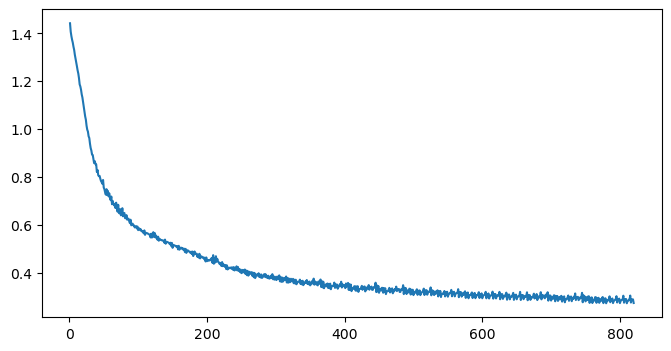

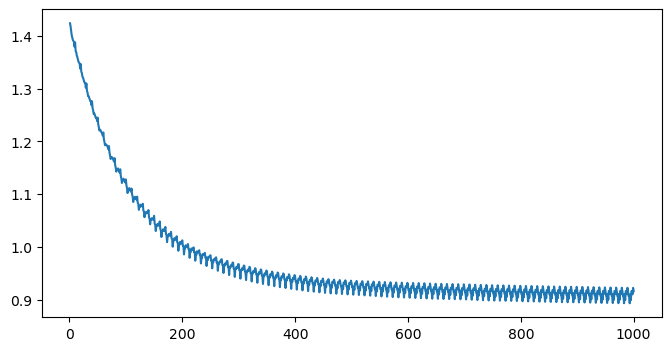

In [14]:
for i in 1:length(hists)
    fig2, ax2 = plt.subplots(1, figsize=(8,4))
    ax2.plot(1:length(hists[i]), hists[i])
end

In [13]:
smpls_transformed

2×100000 Matrix{Float32}:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN